<a href="https://colab.research.google.com/github/androbaza/smlm-seg/blob/main/MMSegmentation_SMLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# condacolab.install_from_url('https://cloud.uni-jena.de/s/KSxnqPEKbfHdofg/download/condacolab-0.1-Linux-x86_64.sh', run_checks=False)
# Install PyTorch
!pip install pytorch=1.10.0 cudatoolkit=11.1 torchvision -c pytorch 
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html

In [ ]:
%%capture
%cd /content/drive/MyDrive/MMsegmentation-data/mmsegmentation
!pip install -e .

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.11.0+cu113 True
0.24.1


## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# import os, skimage
# from skimage.io import imread, imshow 
# import numpy as np

# iSAID_palette = \
#     {
#         0: (0),
#         1: (120),
#         2: (240)
#     }

# palette = {v: k for k, v in iSAID_palette.items()}

# conv_dir = '/content/drive/MyDrive/MMsegmentation-data/dataset_no_rotations/labels/'
# output_dir = '/content/drive/MyDrive/MMsegmentation-data/dataset_no_rotations/labels_gray/'

# for file in os.listdir(conv_dir):
#   img = skimage.io.imread(os.path.join(conv_dir, file))
#   arr_2d = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

#   for c, i in palette.items():
#     m = img == c
#     arr_2d[m] = i

#   skimage.io.imsave(os.path.join(output_dir, file), arr_2d, check_contrast=False)


We need to convert the annotation into semantic map format as an image.

In [ ]:
# # download and unzip
# %cd /content/
# !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
# !tar xf stanford_background.tar.gz

In [ ]:
# # Let's take a look at the dataset
# import mmcv
# import matplotlib.pyplot as plt

# img = mmcv.imread('iccv09Data/images/6000124.jpg')
# plt.figure(figsize=(8, 6))
# plt.imshow(mmcv.bgr2rgb(img))
# plt.show()

In [ ]:
# import mmcv
# import matplotlib.pyplot as plt
# import os.path as osp
# import numpy as np
# from PIL import Image
# # convert dataset annotation to semantic segmentation map
# data_root = 'iccv09Data'
# img_dir = 'images'
# ann_dir = 'labels'
# # define class and plaette for better visualization
# classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
# palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
#            [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
# for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                          '.png')))

In [ ]:
# # Let's take a look at the segmentation map we got
# import matplotlib.patches as mpatches
# img = Image.open('iccv09Data/labels/6000124.png')
# plt.figure(figsize=(8, 6))
# im = plt.imshow(np.array(img.convert('RGB')))

# # create a patch (proxy artist) for every color 
# patches = [mpatches.Patch(color=np.array(palette[i])/255., 
#                           label=classes[i]) for i in range(8)]
# # put those patched as legend-handles into the legend
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
#            fontsize='large')

# plt.show()

In [ ]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

# split train/val set randomly
img_dir = 'images'
ann_dir = 'labels_gray'
# classes = ('Background', 'Microtubule', 'Vesicle')
classes = ('back','Microtubule', 'Vesicle')
# palette = [[0, 0, 0], [128, 255, 0], [0, 255, 255]]
palette = [[40,40,40], [128, 255, 0], [0, 255, 255]]

data_root = '/content/drive/MyDrive/MMsegmentation-data/dataset_no_rotations/'

# split_dir = 'splits'
# mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
#     osp.join(data_root, img_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*4/5)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SMLM_mt_ves4(CustomDataset):
  # CLASSES = ('Background','Microtubule', 'Vesicle')
  # PALETTE = [[0, 0, 0], [128, 255, 0], [0, 255, 255]]
  CLASSES = ('Back','Microtubule', 'Vesicle')
  PALETTE = [[40,40,40], [128, 255, 0], [0, 255, 255]]
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split,
                     reduce_zero_label=False,
                     **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

# deeplabv3plus

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth -P /content/drive/MyDrive/MMsegmentation-data/mmsegmentation/checkpoints/

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam.py')
# cfg = Config.fromfile('configs/segformer/segformer_mit-b5_512x512_160k_ade20k.py')

# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.model.auxiliary_head.loss_decode = dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0, avg_non_ignore=True)
cfg.model.decode_head.loss_decode = dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0, avg_non_ignore=True)

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=False)
cfg.img_scale = (512, 512)
cfg.crop_size = (128, 128)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=True),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/run3'

cfg.runner.max_iters = 200
cfg.log_config.interval = 50
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 100

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.model.pretrained

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet18_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=512,
        in_index=3,
        channels=128,
        dilations=(1, 12, 24, 36),
        c1_in_channels=64,
        c1_channels=12,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=True,
            loss_weight=1.0,
            avg_non_ignore=True)),
    auxiliary_head=dict(
        t

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-05-27 13:05:05,956 - mmseg - INFO - Loaded 1656 images
/content/drive/MyDrive/MMsegmentation-data/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-05-27 13:05:06,143 - mmseg - INFO - Loaded 415 images
2022-05-27 13:05:06,154 - mmseg - INFO - Start running, host: root@9609640263d4, work_dir: /content/drive/MyDrive/MMsegmentation-data/work_dirs/run3
2022-05-27 13:05:06,15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 415/415, 20.5 task/s, elapsed: 20s, ETA:     0s

2022-05-27 13:10:32,264 - mmseg - INFO - per class results:
2022-05-27 13:10:32,266 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 43.31 | 48.99 |
| Microtubule |  0.06 |  0.33 |
|   Vesicle   |  0.0  |  0.0  |
+-------------+-------+-------+
2022-05-27 13:10:32,269 - mmseg - INFO - Summary:
2022-05-27 13:10:32,272 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 42.71 | 14.46 | 16.44 |
+-------+-------+-------+
2022-05-27 13:10:32,275 - mmseg - INFO - Iter(val) [415]	aAcc: 0.4271, mIoU: 0.1446, mAcc: 0.1644, IoU.Background: 0.4331, IoU.Microtubule: 0.0006, IoU.Vesicle: 0.0000, Acc.Background: 0.4899, Acc.Microtubule: 0.0033, Acc.Vesicle: 0.0000


Inference with trained model

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/1000c.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(12, 8))
show_result_pyplot(model, img, result, palette)

# PSPnet

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_loveda/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth -P /content/drive/MyDrive/MMsegmentation-data/mmsegmentation/checkpoints/

--2022-05-27 13:15:54--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_loveda/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196241329 (187M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/MMsegmentation-data/mmsegmentation/checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth’

pspnet_r50-d8_512x5 100%[===================>] 187.15M  8.77MB/s    in 23s     

2022-05-27 13:16:18 (8.28 MB/s) - ‘/content/drive/MyDrive/MMsegmentation-data/mmsegmentation/checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth’ saved [196241329/196241329]



In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x512_80k_loveda.py')
# cfg = Config.fromfile('configs/segformer/segformer_mit-b5_512x512_160k_ade20k.py')

# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

cfg.model.auxiliary_head.loss_decode = dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0, avg_non_ignore=True)
cfg.model.decode_head.loss_decode = dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0, avg_non_ignore=True)

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves4'
cfg.data_root = data_root

# cfg.data.samples_per_gpu = 16
# cfg.data.workers_per_gpu = 8

# cfg.img_norm_cfg = dict(
#     mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=False)
# cfg.img_scale = (512, 512)
# cfg.crop_size = (128, 128)

# train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations', reduce_zero_label=True),
#     dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
#     dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
#     dict(type='RandomFlip', prob=0.5),
#     dict(type='PhotoMetricDistortion'),
#     dict(
#         type='Normalize',
#         mean=[123.675, 116.28, 103.53],
#         std=[58.395, 57.12, 57.375],
#         to_rgb=True),
#     dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_semantic_seg'])
# ]

cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/run2k'

cfg.runner.max_iters = 2000
cfg.log_config.interval = 100
cfg.evaluation.interval = 500
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.model.pretrained

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=True,
            loss_weight=1.0,
            avg_non_ignore=True)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        c

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-05-27 13:58:39,837 - mmseg - INFO - Loaded 1656 images
/content/drive/MyDrive/MMsegmentation-data/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-05-27 13:58:40,437 - mmseg - INFO - Loaded 415 images
2022-05-27 13:58:40,442 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth
2022-05-27 13:58:40,789

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 415/415, 17.8 task/s, elapsed: 23s, ETA:     0s

2022-05-27 14:01:54,076 - mmseg - INFO - per class results:
2022-05-27 14:01:54,078 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|     Back    | 88.41 | 92.88 |
| Microtubule |  41.3 | 64.91 |
|   Vesicle   | 53.97 | 59.17 |
+-------------+-------+-------+
2022-05-27 14:01:54,082 - mmseg - INFO - Summary:
2022-05-27 14:01:54,085 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.16 | 61.22 | 72.32 |
+-------+-------+-------+
2022-05-27 14:01:54,089 - mmseg - INFO - Iter(val) [415]	aAcc: 0.8916, mIoU: 0.6122, mAcc: 0.7232, IoU.Back: 0.8841, IoU.Microtubule: 0.4130, IoU.Vesicle: 0.5397, Acc.Back: 0.9288, Acc.Microtubule: 0.6491, Acc.Vesicle: 0.5917
2022-05-27 14:02:27,824 - mmseg - INFO - Iter [600/2000]	lr: 7.286e-03, eta: 0:08:49, time: 0.570, data_time: 0.235, memory: 2232, decode.loss_ce: 0.0760, decode.acc_seg: 95.4767, aux.loss_ce: 0.0783, aux.acc_seg: 95.3520, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 415/415, 17.2 task/s, elapsed: 24s, ETA:     0s

2022-05-27 14:05:11,781 - mmseg - INFO - per class results:
2022-05-27 14:05:11,785 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|     Back    | 87.76 | 91.18 |
| Microtubule | 42.62 | 71.81 |
|   Vesicle   | 57.86 | 71.32 |
+-------------+-------+-------+
2022-05-27 14:05:11,786 - mmseg - INFO - Summary:
2022-05-27 14:05:11,790 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.67 | 62.75 | 78.1 |
+-------+-------+------+
2022-05-27 14:05:11,794 - mmseg - INFO - Iter(val) [415]	aAcc: 0.8867, mIoU: 0.6275, mAcc: 0.7810, IoU.Back: 0.8776, IoU.Microtubule: 0.4262, IoU.Vesicle: 0.5786, Acc.Back: 0.9118, Acc.Microtubule: 0.7181, Acc.Vesicle: 0.7132
2022-05-27 14:05:45,743 - mmseg - INFO - Iter [1100/2000]	lr: 4.930e-03, eta: 0:05:47, time: 0.580, data_time: 0.243, memory: 2232, decode.loss_ce: 0.0675, decode.acc_seg: 95.8659, aux.loss_ce: 0.0691, aux.acc_seg: 95.7824, loss: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 415/415, 18.0 task/s, elapsed: 23s, ETA:     0s

2022-05-27 14:08:24,864 - mmseg - INFO - per class results:
2022-05-27 14:08:24,867 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|     Back    | 88.03 | 91.67 |
| Microtubule | 42.35 | 68.73 |
|   Vesicle   |  56.0 | 76.71 |
+-------------+-------+-------+
2022-05-27 14:08:24,868 - mmseg - INFO - Summary:
2022-05-27 14:08:24,872 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.87 | 62.13 | 79.04 |
+-------+-------+-------+
2022-05-27 14:08:24,876 - mmseg - INFO - Iter(val) [415]	aAcc: 0.8887, mIoU: 0.6213, mAcc: 0.7904, IoU.Back: 0.8803, IoU.Microtubule: 0.4235, IoU.Vesicle: 0.5600, Acc.Back: 0.9167, Acc.Microtubule: 0.6873, Acc.Vesicle: 0.7671
2022-05-27 14:08:58,640 - mmseg - INFO - Iter [1600/2000]	lr: 2.431e-03, eta: 0:02:34, time: 0.568, data_time: 0.233, memory: 2232, decode.loss_ce: 0.0599, decode.acc_seg: 96.2707, aux.loss_ce: 0.0614, aux.acc_seg: 96.1828, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 415/415, 17.1 task/s, elapsed: 24s, ETA:     0s

2022-05-27 14:11:41,156 - mmseg - INFO - per class results:
2022-05-27 14:11:41,159 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|     Back    | 87.55 | 90.74 |
| Microtubule | 42.75 | 72.07 |
|   Vesicle   | 53.04 | 77.25 |
+-------------+-------+-------+
2022-05-27 14:11:41,160 - mmseg - INFO - Summary:
2022-05-27 14:11:41,165 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.44 | 61.11 | 80.02 |
+-------+-------+-------+
2022-05-27 14:11:41,168 - mmseg - INFO - Iter(val) [415]	aAcc: 0.8844, mIoU: 0.6111, mAcc: 0.8002, IoU.Back: 0.8755, IoU.Microtubule: 0.4275, IoU.Vesicle: 0.5304, Acc.Back: 0.9074, Acc.Microtubule: 0.7207, Acc.Vesicle: 0.7725


Inference with trained model

/content/drive/MyDrive/MMsegmentation-data/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 432x432 with 0 Axes>

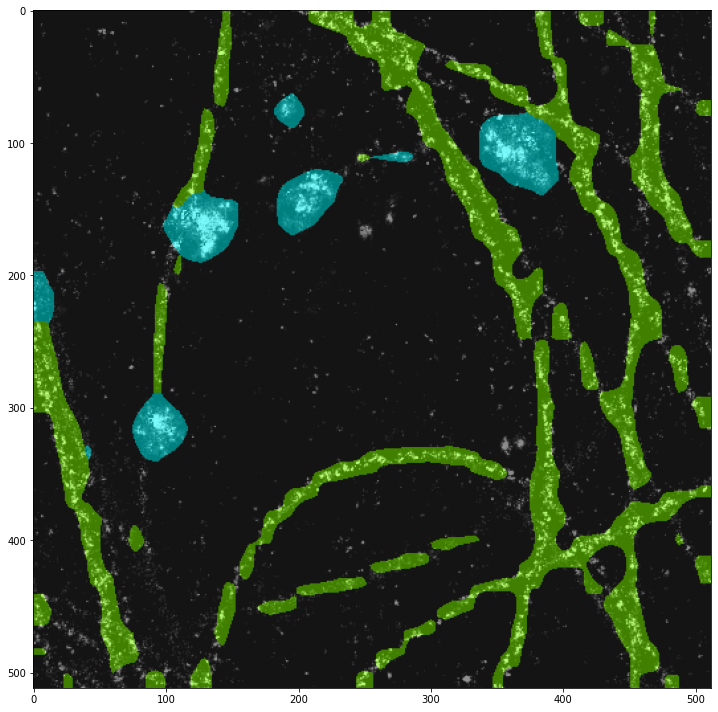

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/1000c.png')
# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/000435.png')
img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/001380.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(6, 6))
show_result_pyplot(model, img, result, palette)